In [1]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')

import psycopg2
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from config.load import load_conf
from db.utils import get_uri_db
from strategy.strategy import Strategy1
from utils.utils import AnnualGranularity, get_candles

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [3]:
start_date = '2020-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

# Test_strategy

In [4]:
candles_EURUSD = candles[(candles['table'] == 'candle1h') & (candles['symbol'] == 'EUR/USD')]

In [5]:
strat = Strategy1(candles_EURUSD, AnnualGranularity.H_1.value)

In [6]:
actions = strat.apply_strategy()

In [7]:
strat.compute_return()

<AxesSubplot:>

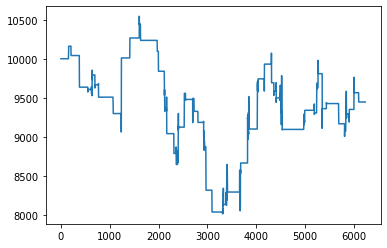

In [8]:
strat.data['return_cumsum'].plot()

In [9]:
strat.data[strat.data['date'] >= '2020-02-03 14:00:00'][:10]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action,position,return,return_cumsum
550,candle1h,2020-02-03 14:00:00,EUR/USD,1.10637,1.10479,1.10456,1.10643,10972,0.000899,1.10968,1.10456,11152.0,candle1h,2020-02-03 13:00:00,EUR/USD,1.10665,1.10637,1.10623,1.10673,5673.0,0.000841,1.10968,1.10589,11152.0,0,0,-0.0,9636.0
551,candle1h,2020-02-03 15:00:00,EUR/USD,1.10479,1.10564,1.10364,1.10604,20432,0.000986,1.10968,1.10364,20432.0,candle1h,2020-02-03 14:00:00,EUR/USD,1.10637,1.10479,1.10456,1.10643,10972.0,0.000899,1.10968,1.10456,11152.0,0,0,0.0,9636.0
552,candle1h,2020-02-03 16:00:00,EUR/USD,1.10564,1.10626,1.10543,1.10663,10964,0.000988,1.10966,1.10364,20432.0,candle1h,2020-02-03 15:00:00,EUR/USD,1.10479,1.10564,1.10364,1.10604,20432.0,0.000986,1.10968,1.10364,20432.0,-1,-1,-62.0,9574.0
553,candle1h,2020-02-03 17:00:00,EUR/USD,1.10626,1.10593,1.10582,1.10670,6501,0.000961,1.10965,1.10364,20432.0,candle1h,2020-02-03 16:00:00,EUR/USD,1.10564,1.10626,1.10543,1.10663,10964.0,0.000988,1.10966,1.10364,20432.0,1,-1,33.0,9607.0
554,candle1h,2020-02-03 18:00:00,EUR/USD,1.10593,1.10620,1.10588,1.10644,4693,0.000920,1.10915,1.10364,20432.0,candle1h,2020-02-03 17:00:00,EUR/USD,1.10626,1.10593,1.10582,1.10670,6501.0,0.000961,1.10965,1.10364,20432.0,0,0,0.0,9607.0
555,candle1h,2020-02-03 19:00:00,EUR/USD,1.10620,1.10641,1.10615,1.10660,3960,0.000914,1.10898,1.10364,20432.0,candle1h,2020-02-03 18:00:00,EUR/USD,1.10593,1.10620,1.10588,1.10644,4693.0,0.000920,1.10915,1.10364,20432.0,0,0,0.0,9607.0
556,candle1h,2020-02-03 20:00:00,EUR/USD,1.10641,1.10588,1.10577,1.10645,4399,0.000902,1.10882,1.10364,20432.0,candle1h,2020-02-03 19:00:00,EUR/USD,1.10620,1.10641,1.10615,1.10660,3960.0,0.000914,1.10898,1.10364,20432.0,0,0,-0.0,9607.0
557,candle1h,2020-02-03 21:00:00,EUR/USD,1.10588,1.10618,1.10584,1.10621,2118,0.000884,1.10869,1.10364,20432.0,candle1h,2020-02-03 20:00:00,EUR/USD,1.10641,1.10588,1.10577,1.10645,4399.0,0.000902,1.10882,1.10364,20432.0,0,0,0.0,9607.0
558,candle1h,2020-02-03 22:00:00,EUR/USD,1.10618,1.10599,1.10597,1.10632,1381,0.000879,1.10869,1.10364,20432.0,candle1h,2020-02-03 21:00:00,EUR/USD,1.10588,1.10618,1.10584,1.10621,2118.0,0.000884,1.10869,1.10364,20432.0,0,0,-0.0,9607.0
559,candle1h,2020-02-03 23:00:00,EUR/USD,1.10599,1.10630,1.10596,1.10637,1322,0.000881,1.10869,1.10364,20432.0,candle1h,2020-02-03 22:00:00,EUR/USD,1.10618,1.10599,1.10597,1.10632,1381.0,0.000879,1.10869,1.10364,20432.0,0,0,0.0,9607.0


In [9]:
strat.compute_performance()

0          NaN
1       1.0000
2       1.0000
3       1.0000
4       1.0000
         ...  
6233    0.9446
6234    0.9446
6235    0.9446
6236    0.9446
6237    0.9446
Name: return_cumsum, Length: 6238, dtype: float64
0          NaN
1       1.0000
2       1.0000
3       1.0000
4       1.0000
         ...  
6233    0.9446
6234    0.9446
6235    0.9446
6236    0.9446
6237    0.9446
Name: return_cumsum, Length: 6238, dtype: float64
0            NaN
1       1.000178
2       1.000375
3       0.999581
4       0.999143
          ...   
6233    1.086792
6234    1.088121
6235    1.087756
6236    1.087720
6237    1.088005
Name: close, Length: 6238, dtype: float64


In [10]:
strat.indicators

{'CAGR': -0.053758804953919714,
 'Volatility': 0.2563202869566342,
 'SharpeRatio': -0.22923977517183755,
 'Calmar': 1.1980908723240669}

In [9]:
mask = (strat.data['high'] >= strat.data['previous_roll_max'])
strat.data[mask]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
949606,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308,0.005080,1.10536,1.07785,418308.0,candle1d,2020-02-27,EUR/USD,1.08870,1.09970,1.08854,1.10072,331934.0,0.004841,1.10486,1.07785,331934.0,0
949607,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988,0.005054,1.10745,1.07785,418308.0,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308.0,0.005080,1.10536,1.07785,418308.0,0
949608,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031,0.005580,1.11853,1.07785,486031.0,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988.0,0.005054,1.10745,1.07785,418308.0,0
949609,candle1d,2020-03-03,EUR/USD,1.11449,1.11772,1.10958,1.12140,509082,0.006132,1.12140,1.07785,509082.0,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031.0,0.005580,1.11853,1.07785,486031.0,0
949611,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027,0.006802,1.12458,1.07785,509082.0,candle1d,2020-03-04,EUR/USD,1.11772,1.11390,1.10961,1.11881,342226.0,0.006343,1.12140,1.07785,509082.0,0
949612,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869,0.007220,1.13553,1.07785,580869.0,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027.0,0.006802,1.12458,1.07785,509082.0,0
949613,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591,0.007488,1.13974,1.07785,580869.0,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869.0,0.007220,1.13553,1.07785,580869.0,0
949614,candle1d,2020-03-09,EUR/USD,1.13884,1.13999,1.13568,1.14974,956742,0.008021,1.14974,1.07785,956742.0,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591.0,0.007488,1.13974,1.07785,580869.0,0
949660,candle1d,2020-05-01,EUR/USD,1.09456,1.09846,1.09352,1.10196,222060,0.007317,1.10196,1.07276,390717.0,candle1d,2020-04-30,EUR/USD,1.08779,1.09456,1.08335,1.09735,390717.0,0.007230,1.09922,1.07276,390717.0,0
949682,candle1d,2020-05-27,EUR/USD,1.09791,1.10174,1.09343,1.10315,420202,0.006810,1.10315,1.07672,420202.0,candle1d,2020-05-26,EUR/USD,1.09023,1.09791,1.08973,1.09966,241409.0,0.006650,1.10091,1.07672,292042.0,0


In [18]:
strat.data[strat.data['action'] != 0]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
148323,candle,2020-01-03 07:15:00,EUR/USD,1.11639,1.11614,1.11607,1.11650,1168,0.000228,1.11722,1.11607,1381.0,candle,2020-01-03 07:10:00,EUR/USD,1.11713,1.11639,1.11637,1.11720,1381.0,0.000220,1.11722,1.11637,1381.0,-1
148333,candle,2020-01-03 08:05:00,EUR/USD,1.11570,1.11577,1.11566,1.11587,944,0.000307,1.11722,1.11526,2158.0,candle,2020-01-03 08:00:00,EUR/USD,1.11539,1.11570,1.11526,1.11595,2158.0,0.000306,1.11722,1.11526,2158.0,1
148417,candle,2020-01-03 15:05:00,EUR/USD,1.11565,1.11591,1.11541,1.11608,1933,0.000426,1.11679,1.11359,4124.0,candle,2020-01-03 15:00:00,EUR/USD,1.11529,1.11565,1.11529,1.11679,4124.0,0.000400,1.11679,1.11359,4124.0,1
148464,candle,2020-01-03 19:00:00,EUR/USD,1.11679,1.11656,1.11651,1.11689,1080,0.000237,1.11742,1.11651,1408.0,candle,2020-01-03 18:55:00,EUR/USD,1.11689,1.11679,1.11666,1.11694,459.0,0.000231,1.11742,1.11666,1408.0,-1
148826,candle,2020-01-07 00:05:00,EUR/USD,1.11944,1.11956,1.11944,1.11960,420,0.000112,1.11982,1.11938,577.0,candle,2020-01-07 00:00:00,EUR/USD,1.11961,1.11944,1.11938,1.11962,577.0,0.000109,1.11982,1.11938,577.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221931,candle,2020-12-23 01:40:00,EUR/USD,1.21796,1.21794,1.21785,1.21813,837,0.000427,1.21856,1.21547,2470.0,candle,2020-12-23 01:35:00,EUR/USD,1.21751,1.21796,1.21741,1.21796,943.0,0.000435,1.21880,1.21547,2470.0,1
221996,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985,0.000223,1.21906,1.21800,1489.0,candle,2020-12-23 07:00:00,EUR/USD,1.21845,1.21848,1.21800,1.21852,1489.0,0.000197,1.21905,1.21800,1489.0,-1
221997,candle,2020-12-23 07:10:00,EUR/USD,1.21903,1.21898,1.21893,1.21926,891,0.000232,1.21926,1.21800,1489.0,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985.0,0.000223,1.21906,1.21800,1489.0,1
222163,candle,2020-12-23 21:00:00,EUR/USD,1.21960,1.21916,1.21911,1.21963,1063,0.000373,1.21973,1.21740,1442.0,candle,2020-12-23 20:55:00,EUR/USD,1.21876,1.21961,1.21876,1.21973,1442.0,0.000363,1.21973,1.21732,1442.0,1
